# GP Multiple runs on an arbitrary Symbolic Regression Problem.

To make our code truly general, it is important to be able to read data in from a file and perform Symbolic Regression on it.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


Import our tools. This time we also use **csv**.

In [2]:
import operator
import math
import random

import numpy

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

import csv



import matplotlib.pyplot as plt

import itertools
import networkx as nx



Set our Genetic Programming parameters, one of which is now the number of runs.

In [3]:
# Genetic Programming constants:
POPULATION_SIZE = 20
P_CROSSOVER = 0.9
P_MUTATION = 0.01
MAX_GENERATIONS = 50
HALL_OF_FAME_SIZE = 10

N_RUNS = 30




Set the random seed. 

In [4]:
RANDOM_SEED = 412
random.seed(RANDOM_SEED)

GP-Specific constants.

In [5]:
MIN_TREE_HEIGHT = 3
MAX_TREE_HEIGHT = 5
LIMIT_TREE_HEIGHT = 17
MUT_MIN_TREE_HEIGHT = 0
MUT_MAX_TREE_HEIGHT = 2

Read in the data.

In [6]:
with open("randomData.csv") as symbRegData:
    n_rows = sum(1 for line in symbRegData)
with open("randomData.csv") as symbRegData:
    reader = csv.reader(symbRegData)
    data = list(list(float(elem) for elem in row) for row in reader)

Define our fitness function.

In [7]:
def evalSymbReg(individual):
    # Transform the tree expression in a callable function
    func = toolbox.compile(expr=individual)
    # Evaluate the sum of squared difference between the expression and the target values
    diff = sum((func(*row[:-1]) - row[-1])**2 for row in data)
    error = diff/n_rows
    if (error>10):
        error=10
    #return error, individual.height
    nodes, edges, labels = gp.graph(individual)
    return error, len(nodes)

Define a protected division function.

In [8]:
def protectedDiv(left, right):
    try:
        return left / right
    except ZeroDivisionError:
        return 1

Add our functions and terminals. 

In [9]:
pset = gp.PrimitiveSet("MAIN", 5) # number of inputs!!!
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(protectedDiv, 2)
pset.addPrimitive(operator.neg, 1)
pset.addPrimitive(math.cos, 1)
pset.addPrimitive(math.sin, 1)
pset.addEphemeralConstant("rand101", lambda: random.random())


Create our toolbox. This is very similar to the Symbolic Regression notebook except we are using the parameters declared up above.

In [10]:
toolbox = base.Toolbox()

creator.create("FitnessMin", base.Fitness, weights=(-1.0,-1.0))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

toolbox.register("evaluate", evalSymbReg)
#toolbox.register("select", tools.selNSGA2)
toolbox.register("select", tools.selTournament, tournsize=5)

toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=5)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

Create our statistics. These are a bit more complex than the GA ones because we want to keep track of fitness and size for all runs.

In [11]:
maxListFitness = []
avgListFitness = []
minListFitness = []
stdListFitness = []

maxListSize = []
avgListSize = []
minListSize = []
stdListSize = []

Now the magic happens and we run **N_RUNS** times. Always start with a small number of runs and generations to make sure that everything is working properly before you commit to a larger number. That way, if something goes horribly wrong, Python won't replicate it 30 times before giving you back control!

In [12]:
for r in range(0, N_RUNS):
    population = toolbox.population(n=POPULATION_SIZE)
    # define the hall-of-fame object:
    hof = tools.HallOfFame(HALL_OF_FAME_SIZE)   


    # Create our statistics
    stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
    stats_size = tools.Statistics(len)
    mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
    mstats.register("avg", numpy.mean)
    mstats.register("std", numpy.std)
    mstats.register("min", numpy.min)
    mstats.register("max", numpy.max)
    
    
    # Which run are we on?
    print("\n\nCurrently on run", r, "of",N_RUNS)
    
    
    # It's usually a good idea to turn off verbose when conducting multiple runs
    population, logbook = algorithms.eaSimple(population,
                                                  toolbox,
                                                  cxpb=P_CROSSOVER,
                                                  mutpb=P_MUTATION,
                                                  ngen=MAX_GENERATIONS,
                                                  stats=mstats,
                                                  halloffame=hof,
                                                  verbose=False)
    
    #maxFitnessValues, meanFitnessValues = logbook.chapters['fitness'].select("min", "avg")
    meanFitnessValues, stdFitnessValues, minFitnessValues, maxFitnessValues  = logbook.chapters['fitness'].select("avg", "std", "min", "max")
    meanSizeValues, stdSizeValues, minSizeValues, maxSizeValues  = logbook.chapters['size'].select("avg", "std", "min", "max")


    # Save statistics for this run:
    avgListFitness.append(meanFitnessValues)
    stdListFitness.append(stdFitnessValues)
    minListFitness.append(minFitnessValues)
    maxListFitness.append(maxFitnessValues)
    
    avgListSize.append(meanSizeValues)
    stdListSize.append(stdSizeValues)
    minListSize.append(minSizeValues)
    maxListSize.append(maxSizeValues)

    # print info for best solution found:
    best = hof.items[0]
    print("-- Best Individual = ", best)
    print("-- length={}, height={}".format(len(best), best.height))
    print("-- Best Fitness = ", best.fitness.values[0])





Currently on run 0 of 5
-- Best Individual =  protectedDiv(ARG0, 0.7089290380529948)
-- length=3, height=1
-- Best Fitness =  0.1121353026506795


Currently on run 1 of 5
-- Best Individual =  cos(cos(add(sub(add(ARG0, ARG1), protectedDiv(ARG1, cos(sin(cos(add(sub(ARG1, ARG1), ARG1)))))), sin(mul(add(sin(sub(add(ARG0, ARG1), protectedDiv(add(sub(ARG1, ARG1), ARG1), cos(sin(cos(add(sub(neg(ARG4), ARG1), ARG1))))))), ARG1), mul(add(sin(sub(add(ARG0, ARG1), protectedDiv(ARG1, cos(sin(cos(add(ARG1, sub(add(ARG0, ARG1), ARG0)))))))), ARG1), ARG2))))))
-- length=62, height=16
-- Best Fitness =  0.09751538961932724


Currently on run 2 of 5
-- Best Individual =  sin(add(ARG0, ARG3))
-- length=4, height=2
-- Best Fitness =  0.09582974731939574


Currently on run 3 of 5
-- Best Individual =  add(ARG0, mul(ARG4, ARG3))
-- length=5, height=2
-- Best Fitness =  0.046733916486925334


Currently on run 4 of 5
-- Best Individual =  neg(neg(ARG0))
-- length=3, height=2
-- Best Fitness =  0.154503766

Create our graphs using the averages across all the runs. Notice how we use standard deviation to show how much variation there is in the runs. 

Notice that if there's a big discrepancy between best and average the graphs can look like there's virtually no variation in the best score. If this happens, the first thing to do is verify if that is actually happening; you can do that by commenting out this line:

**plt.errorbar(x, avgArray.mean(0), yerr=stdArray.mean(0),label="Average",color="Red")**

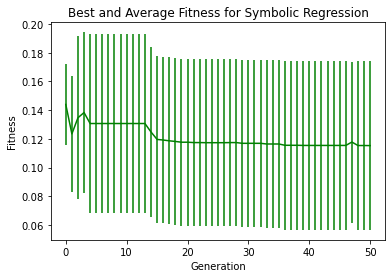

In [13]:
# Genetic Programming is done (all runs) - plot statistics:
x = numpy.arange(0, MAX_GENERATIONS+1)
avgArray = numpy.array(avgListFitness)
stdArray = numpy.array(stdListFitness)
minArray = numpy.array(minListFitness)
maxArray = numpy.array(maxListFitness)
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('Best and Average Fitness for Symbolic Regression')
#plt.errorbar(x, avgArray.mean(0), yerr=stdArray.mean(0),label="Average",color="Red")
plt.errorbar(x, minArray.mean(0), yerr=minArray.std(0),label="Best", color="Green")
plt.show()

Show the graph for size.

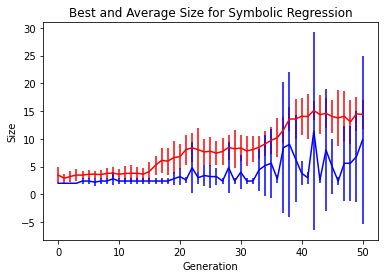

In [14]:
# Genetic Programming is done (all runs) - plot statistics:
x = numpy.arange(0, MAX_GENERATIONS+1)
avgArray = numpy.array(avgListSize)
stdArray = numpy.array(stdListSize)
minArray = numpy.array(minListSize)
maxArray = numpy.array(maxListSize)
plt.xlabel('Generation')
plt.ylabel('Size')
plt.title('Best and Average Size for Symbolic Regression')
plt.errorbar(x, avgArray.mean(0), yerr=stdArray.mean(0),label="Average",color="Red")
plt.errorbar(x, minArray.mean(0), yerr=minArray.std(0),label="Best", color="Blue")
plt.show()